In [6]:
import d4rl
import gym
import torch
import numpy as np
from simple_models import GaussianPolicy
from utils import Args, rollout, ReplayMemory
import umap
import bokeh
from bokeh.io import output_notebook
import bokeh.plotting as bpl
output_notebook()

Loading BokehJS ...

In [5]:
import pickle
with open("pointgoal_envpool.pkl", "rb") as f:
    env_pool = pickle.load(f)

In [21]:
states_dataset = env_pool.return_all()[0]
next_states_dataset = env_pool.return_all()[3]
expert_pool = ReplayMemory(states_dataset, next_states_dataset)
dim = states_dataset.shape[-1]

states_std = states_dataset.std(0)
states_std[states_std == 0] = 1
# TO INCLUDE NEXT STATE STD
normalization = states_dataset.mean(0), states_std, next_states_dataset.mean(0)
policy = GaussianPolicy(
    dim,
    dim,
#     normalization=normalization,
#     hidden_sizes=(512, 512),
    activation="tanh",
)

policy_optim = torch.optim.Adam(policy.parameters())

In [23]:
loss_buf = []
val_ret_buf = []
for epoch in range(1000):
    epoch_loss = []
    for expert_states, expert_actions in expert_pool.batches(256):
        expert_states = torch.FloatTensor(expert_states).to(policy.device)
        expert_actions = torch.FloatTensor(expert_actions).to(policy.device)
        policy_optim.zero_grad()
        mean, _, std = policy(expert_states)
#         action = torch.distributions.Normal(loc=mean, scale=std).rsample()
#         loss = torch.nn.MSELoss()(action, expert_actions)
        loss = torch.nn.MSELoss()(mean, expert_actions)
#         log_prob, _, _ = policy.log_prob(expert_states, expert_actions)
#         loss = -log_prob.mean()
        epoch_loss.append(loss.item())
        loss.backward()
        policy_optim.step()
    loss_buf.append(np.mean(epoch_loss))
    print(np.mean(epoch_loss))

1.79740717290323
1.788445406322238
1.7971257514591459
1.7965730987017667
1.7957719262642196
1.7956965890111802
1.8066720026957839
1.7852495712569998
1.783121727689912
1.779005860980553
1.7930099043665053
1.77036223834074
1.7722302856324594
1.7856530615046053
1.7750710475293896
1.774260721629179
1.7763143581680105
1.7880917817731448
1.763250101970721
1.76736089700385
1.7550223296201681
1.7622849745086477
1.7692242951332768
1.7850488786455951
1.7793590026565744
1.75119035455245
1.7532041404820695
1.7430546540248244
1.7737804530542107
1.7577866949612582
1.7579903285714644
1.7719266822066488
1.7480255289922786
1.741712995722324
1.7408017010628423
1.7467229984983612
1.7595939440063284
1.75119033644471
1.7559924865070777
1.7345066010197507
1.753752100316784
1.7394373975222623
1.745145497442801
1.7505206412906889
1.752062799055365
1.7382587918752357
1.7579193281221994
1.7383068875421452
1.7490620929983598
1.7576845522168316
1.7345251644713968
1.7280685584756392
1.7402909737599046
1.7421648517

In [14]:
plot = bpl.figure()
plot.line(np.arange(len(loss_buf)), loss_buf)
bpl.show(plot)

In [17]:
states, actions, rewards, next_states, _ = env_pool.sample(256)
data = torch.FloatTensor(states).to(policy.device)
pred_next_states, _, _ = policy(data)
pred_next_states = pred_next_states.cpu().detach().numpy()
abs(next_states - pred_next_states).mean(0)

array([2.23445397, 9.5316437 , 0.14675229, 0.10601185, 0.08127695,
       0.10042531, 0.15694984, 0.15814394, 0.13028866, 0.09413259,
       0.04617208, 0.01705343, 0.03199552, 0.09782442, 0.15540891,
       0.17126793, 0.10280179, 0.0628561 , 0.0929077 , 0.01272784,
       0.02045986, 0.88330867, 0.2599269 , 0.26153174, 0.2713567 ,
       0.24747271, 0.21485815, 0.21208684, 0.18714775, 0.20286478,
       0.24688297, 0.24246286, 0.2208526 , 0.20940029, 0.20402306,
       0.23259568, 0.22457969, 0.24698905, 0.28932574, 0.2306614 ,
       0.01231772, 0.0877835 , 0.07540094, 0.07023652, 0.08534026,
       0.11757838, 0.11766317, 0.0951386 , 0.08154748, 0.05532329,
       0.05789182, 0.06744247, 0.06743405, 0.09469024, 0.12533091,
       0.0920456 , 0.08437895, 0.28916696, 0.10416537, 0.01337526])

/home/andrew/miniconda3/envs/offline-saferl/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


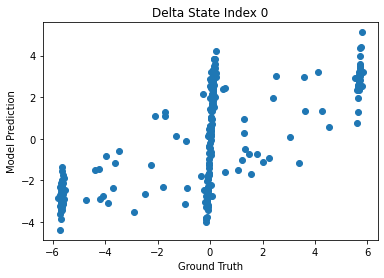

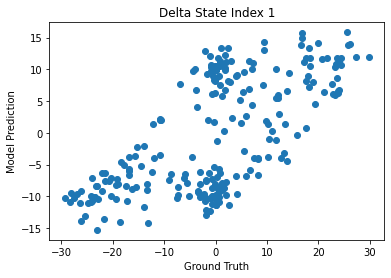

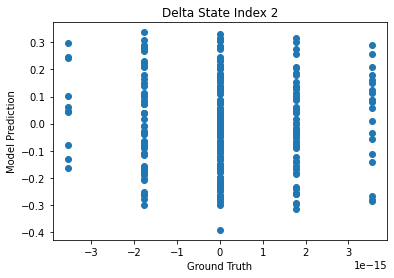

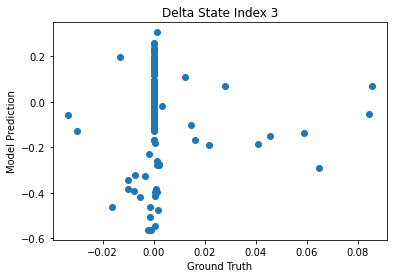

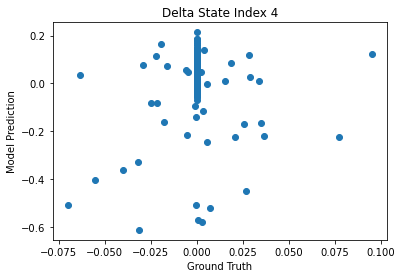

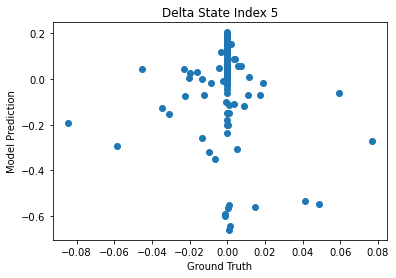

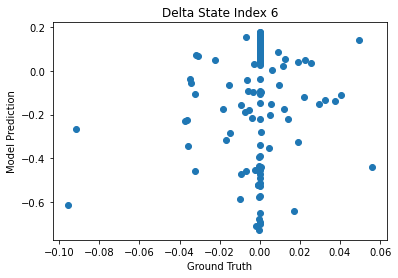

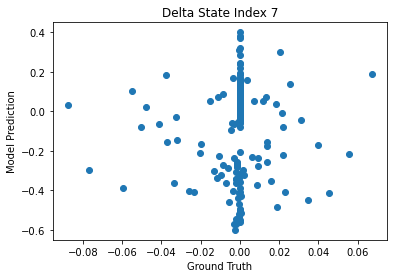

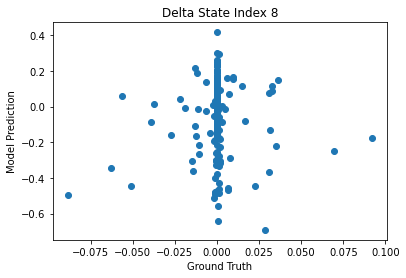

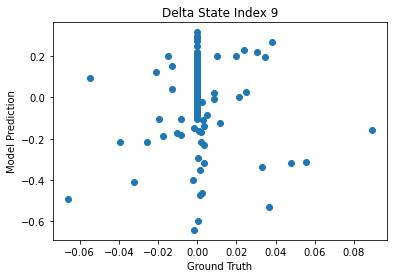

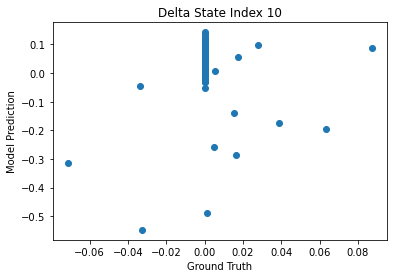

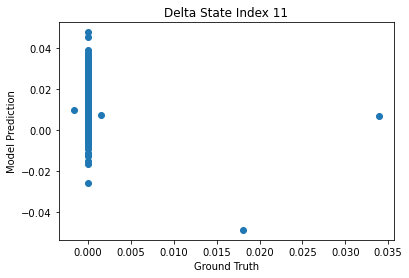

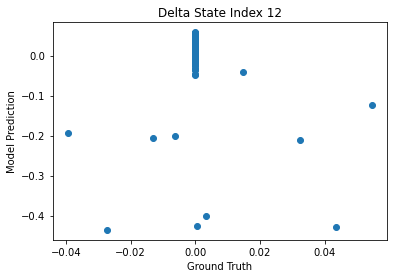

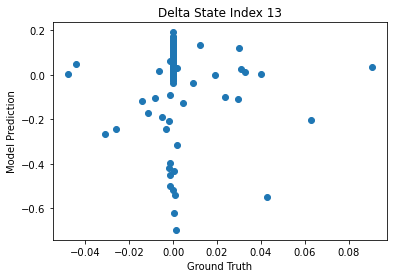

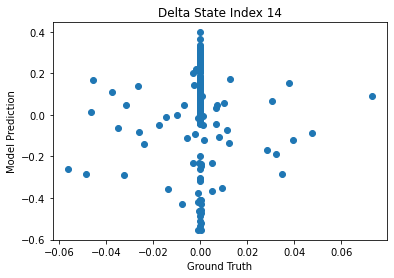

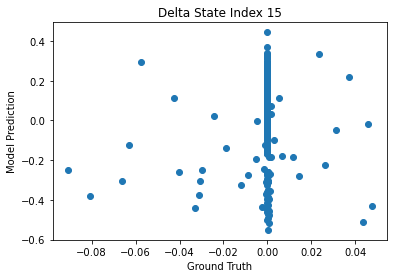

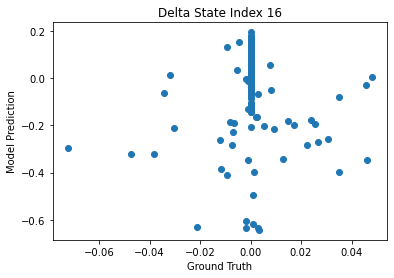

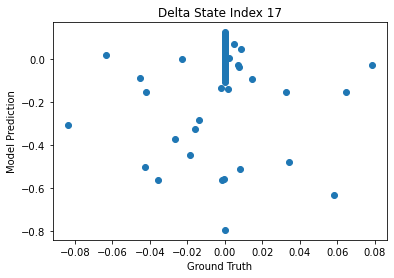

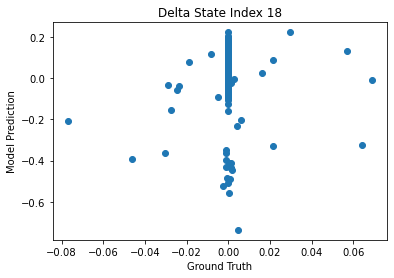

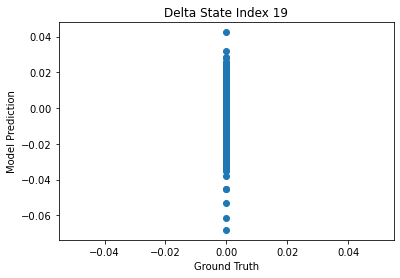

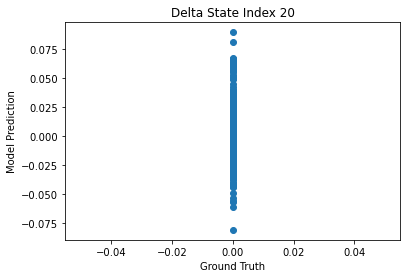

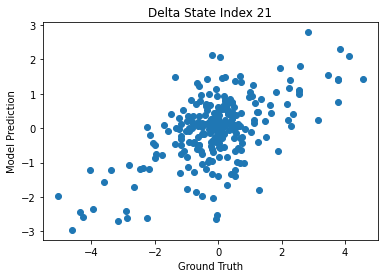

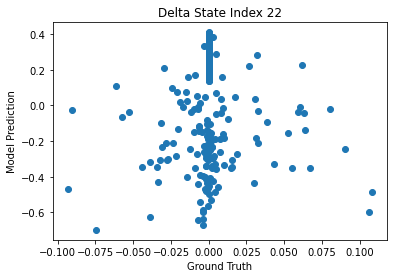

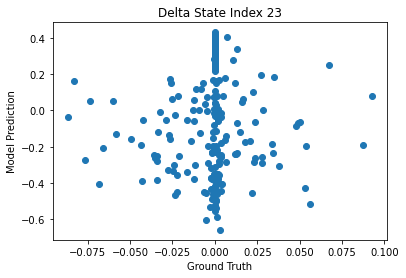

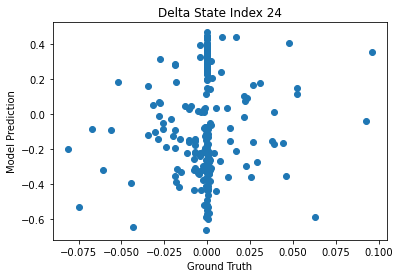

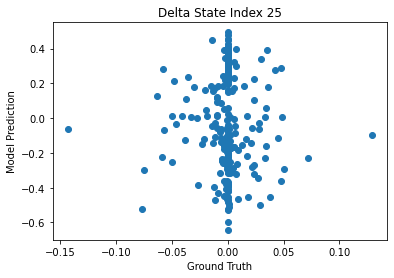

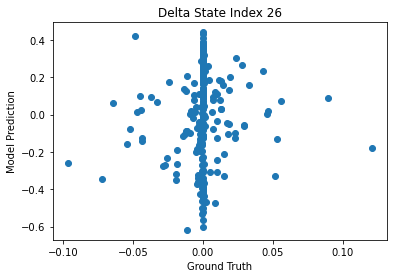

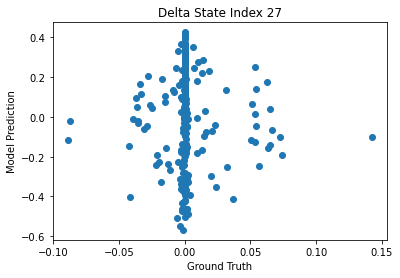

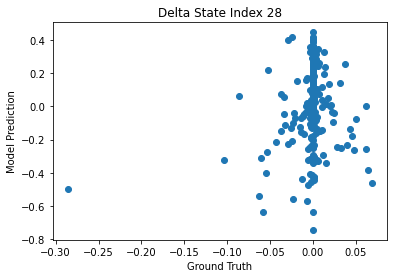

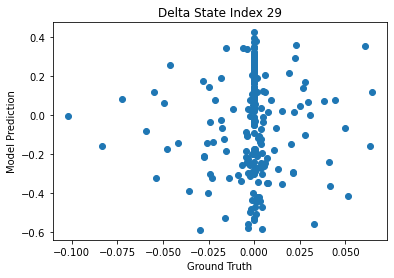

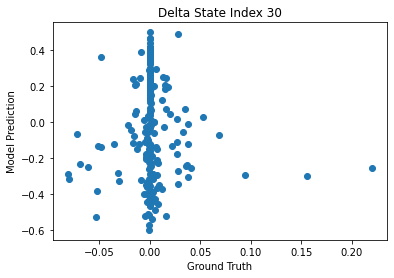

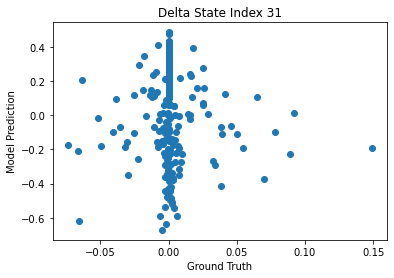

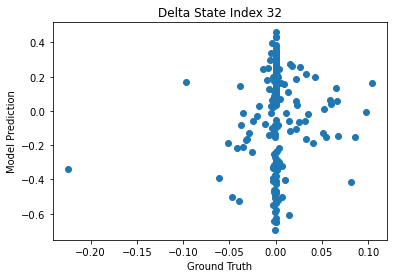

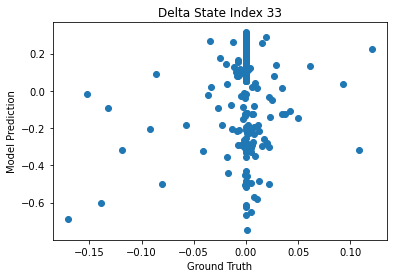

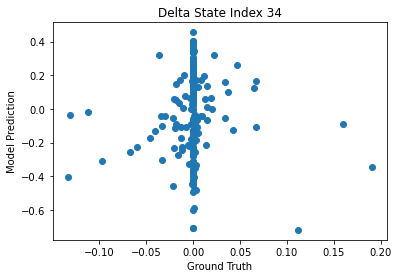

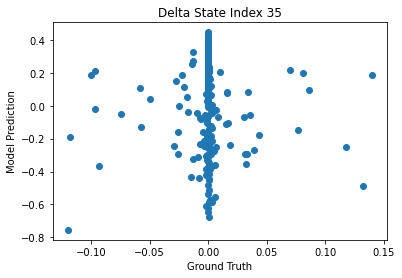

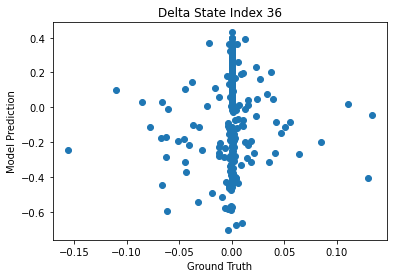

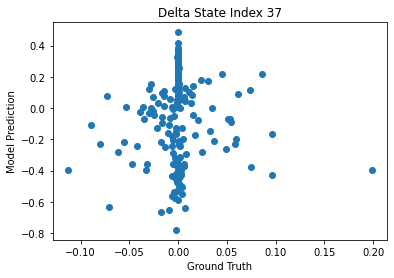

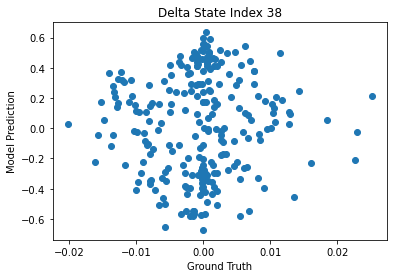

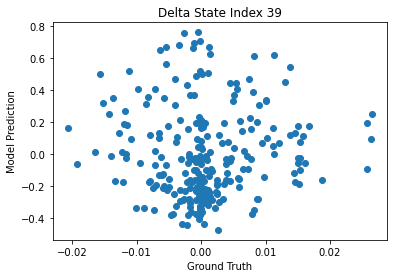

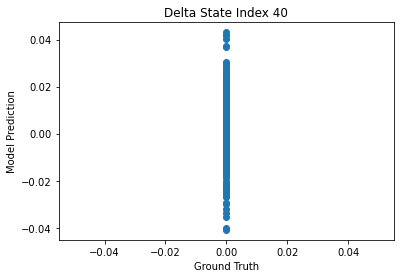

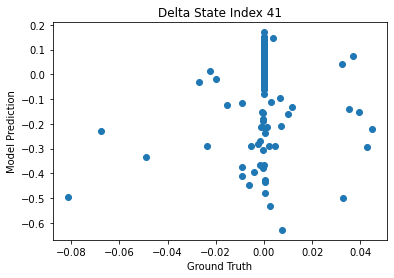

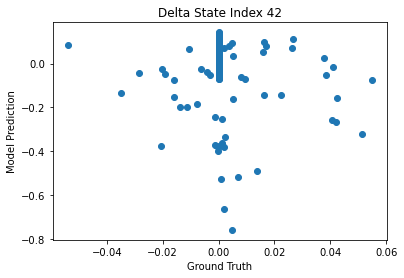

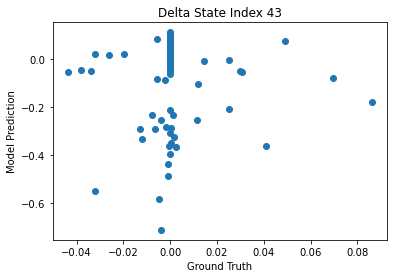

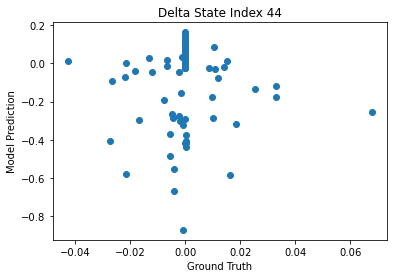

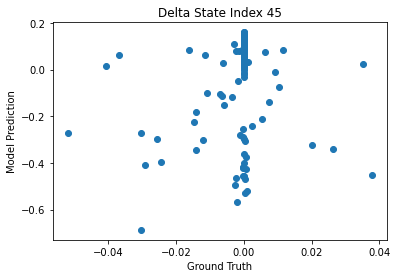

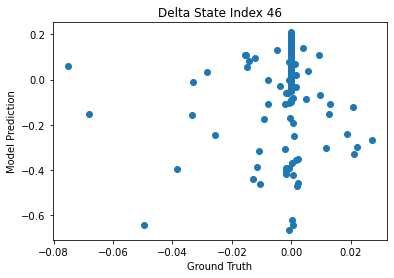

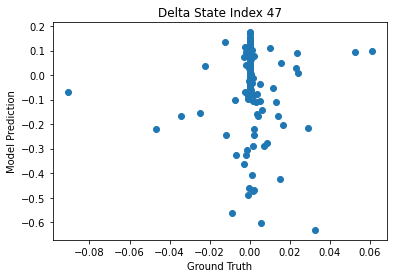

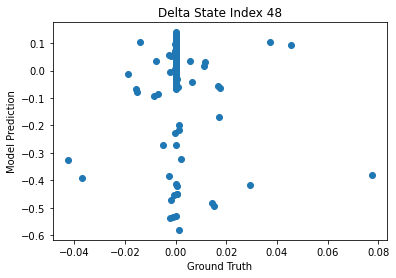

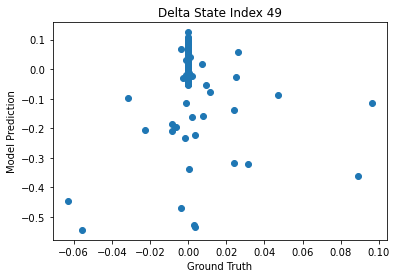

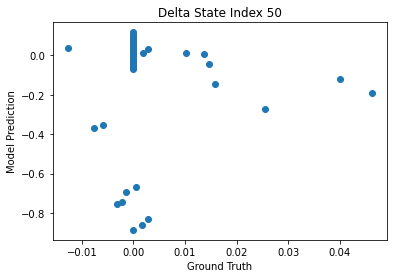

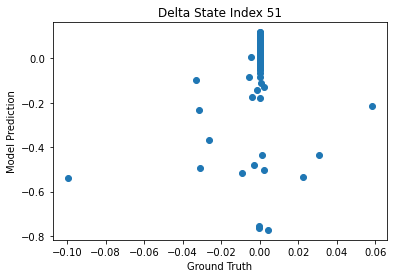

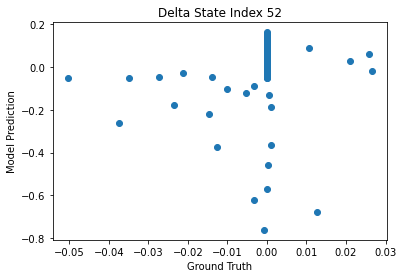

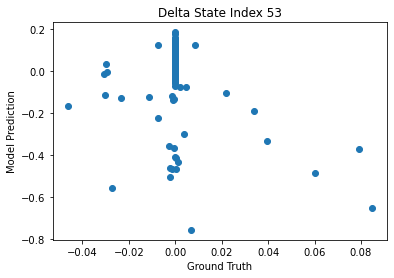

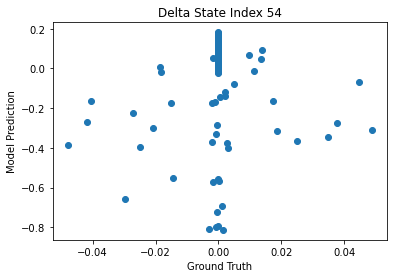

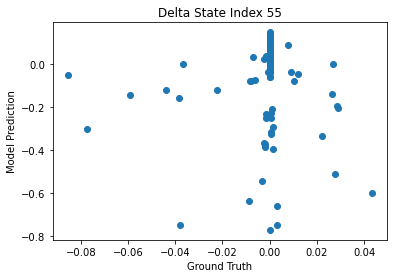

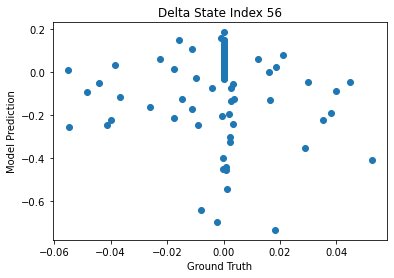

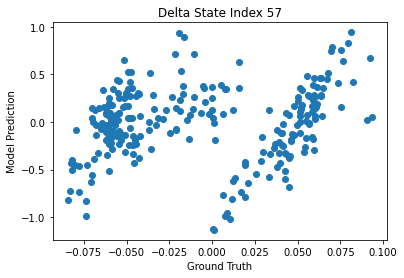

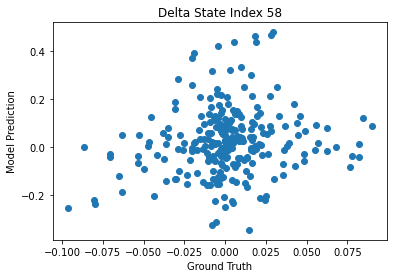

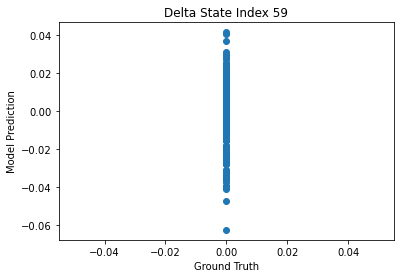

<Figure size 432x288 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt

for i in range(next_states.shape[1]):
    plt.plot(next_states[:,i] - states[:,i], pred_next_states[:,i] - states[:,i], "o")
    plt.title(f"Delta State Index {i}")
    plt.xlabel("Ground Truth")
    plt.ylabel("Model Prediction")
    plt.figure()